<a href="https://colab.research.google.com/github/DrFaus/benckmark_nonlinear_systems/blob/main/MedicionNoLinealidad/Nonlinear_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Nonlinearity assessment of chemical processes. Casos de estudio

Fakhroleslam, Mohammad & Bozorgmehry Boozarjomehry, Ramin & Pazhooh, Faramarz. (2015). Nonlinearity assessment of chemical processes. Scientia Iranica. 22. 967-980.
## Abstract
One of the most important issues in controller design and analysis of a nonlinear system is its degree of nonlinearity. Helbig et al. proposed a method in which the system, along with a linear reference model (which is the sum of a couple of first order transfer functions), is stimulated with a set of input patterns. The outputs of these systems are then compared and the nonlinearity measure of the system is obtained as the normalized difference between the outputs of these two systems. In this paper, the linear reference model is replaced with two simpler linear ones. The proposed method has been used for assessment of the nonlinearity measure of various nonlinear systems that are used as standard benchmarks by the nonlinear process control research community. The results show that, despite the use of this simpler model with less parameters, the calculated nonlinearity measure is almost similar to the one obtained by Helbig's method. Furthermore, the nonlinearity measure obtained by the proposed method can be calculated very much faster.

In [ ]:
#@title Importaciones
import matplotlib.pyplot as plt
from math import exp
from random import normalvariate, random
from numpy import mean
import numpy as np
import control as ct

In [ ]:
# @title Runge Kutta, una variable
def runge_kutta_1(fun, y, u, h):
  '''
  function y_next = runge_kutta_1(fun, y, u, h)

  Un paso del método Dormand–Prince RK 5(4)7 para una ecuación (1D).

  Ecuación:
    dy/dt = f(y, u)

  Parámetros
    y   : estado actual (escalar)
    u   : entrada (constante durante el paso)
    h   : tamaño de paso (escalar)
    fun : función: k = fun(y, u)

  Retorna
    y_next : estado tras avanzar un paso h (aprox. de orden 5)
  '''

  # Matriz A (coeficientes Dormand–Prince)
  a21 = 1/5
  a31, a32 = 3/40, 9/40
  a41, a42, a43 = 44/45, -56/15, 32/9
  a51, a52, a53, a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
  a61, a62, a63, a64, a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
  a71, a72, a73, a74, a75, a76 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

  # Pesos b (orden 5)
  b1, b2, b3, b4, b5, b6, b7 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0

  # k1
  k1 = fun(y, u)

  # k2
  y2 = y + h * a21 * k1
  k2 = fun(y2, u)

  # k3
  y3 = y + h * (a31 * k1 + a32 * k2)
  k3 = fun(y3, u)

  # k4
  y4 = y + h * (a41 * k1 + a42 * k2 + a43 * k3)
  k4 = fun(y4, u)

  # k5
  y5 = y + h * (a51 * k1 + a52 * k2 + a53 * k3 + a54 * k4)
  k5 = fun(y5, u)

  # k6
  y6 = y + h * (a61 * k1 + a62 * k2 + a63 * k3 + a64 * k4 + a65 * k5)
  k6 = fun(y6, u)

  # k7 (etapa final para evaluar)
  y7 = y + h * (a71 * k1 + a72 * k2 + a73 * k3 + a74 * k4 + a75 * k5 + a76 * k6)
  k7 = fun(y7, u)

  # Combinación orden 5
  y_next = y + h * (b1*k1 + b2*k2 + b3*k3 + b4*k4 + b5*k5 + b6*k6 + b7*k7)

  return y_next

In [ ]:
#@title Runge Kutta 2x2
def runge_kutta_2(fun, y1, y2, u, h):
  '''
  function [y1_next, y2_next, err_est] = runge_kutta_2(fun, y1, y2, u, h)
  RUNGE_KUTTA5  Un paso del método Dormand–Prince RK 5(4)7 para sistema 2x2.

  [y1_next, y2_next, err_est] = RUNGE_KUTTA5(fun, y1, y2, u, h)

  Sistema:
  dy1/dt = f1(y1, y2, u)
  dy2/dt = f2(y1, y2, u)

  Parámetros
  y1, y2 : estado actual (escalares)
  h      : tamaño de paso (escalar)
  fun    : function handle:  [f1, f2] = fun(y1, y2, u)
  u      : entrada (constante durante el paso)

  Retorna
  y1_next, y2_next : estado tras avanzar un paso h (aprox. de orden 5)
  err_est          : estimación de error local (norma 2 de [e1 e2], orden 4)

  Notas:
  - Método Dormand–Prince con pares embebidos (5º/4º). Coeficientes estándar.
  - err_est puede usarse para control adaptativo de h.

  Compatibilidad: MATLAB R2014 (sin implicit expansion).
  '''

    # Matriz A
  a21 = 1/5
  a31, a32 = 3/40, 9/40
  a41, a42, a43 = 44/45, -56/15, 32/9
  a51, a52, a53, a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
  a61, a62, a63, a64, a65  = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
  a71, a72, a73, a74, a75, a76 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

  # Pesos b (orden 5) y b_hat (orden 4) para el embebido
  b1, b2, b3, b4, b5, b6, b7 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0

  # k1
  k1_1, k1_2 = fun(y1, y2, u)

  # k2
  y1_2 = y1 + h * a21 * k1_1
  y2_2 = y2 + h * a21 * k1_2
  k2_1, k2_2 = fun(y1_2, y2_2, u)

  # k3
  y1_3 = y1 + h * (a31 * k1_1 + a32 * k2_1)
  y2_3 = y2 + h * (a31 * k1_2 + a32 * k2_2)
  k3_1, k3_2 = fun(y1_3, y2_3, u)

  # k4
  y1_4 = y1 + h * (a41 * k1_1 + a42 * k2_1 + a43 * k3_1)
  y2_4 = y2 + h * (a41 * k1_2 + a42 * k2_2 + a43 * k3_2)
  k4_1, k4_2 = fun(y1_4, y2_4, u)

  # k5
  y1_5 = y1 + h * (a51 * k1_1 + a52 * k2_1 + a53 * k3_1 + a54 * k4_1)
  y2_5 = y2 + h * (a51 * k1_2 + a52 * k2_2 + a53 * k3_2 + a54 * k4_2)
  k5_1, k5_2 = fun(y1_5, y2_5, u)

  # k6
  y1_6 = y1 + h * (a61 * k1_1 + a62 * k2_1 + a63 * k3_1 + a64 * k4_1 + a65 * k5_1)
  y2_6 = y2 + h * (a61 * k1_2 + a62 * k2_2 + a63 * k3_2 + a64 * k4_2 + a65 * k5_2)
  k6_1, k6_2 = fun(y1_6, y2_6, u)

  # k7 (etapa final para la solución de orden 5)
  y1_7 = y1 + h * (a71 * k1_1 + a72 * k2_1 + a73 * k3_1 + a74 * k4_1 + a75 * k5_1 + a76 * k6_1)
  y2_7 = y2 + h * (a71 * k1_2 + a72 * k2_2 + a73 * k3_2 + a74 * k4_2 + a75 * k5_2 + a76 * k6_2)
  k7_1, k7_2 = fun(y1_7, y2_7, u)

  # Combinación orden 5
  y1_5th = y1 + h * (b1 * k1_1 + b2 * k2_1 + b3 * k3_1 + b4 * k4_1 + b5 * k5_1 + b6 * k6_1 + b7 * k7_1)
  y2_5th = y2 + h * (b1 * k1_2 + b2 * k2_2 + b3 * k3_2 + b4 * k4_2 + b5 * k5_2 + b6 * k6_2 + b7 * k7_2)

  # Salida: solución 5º orden
  y1_next = y1_5th
  y2_next = y2_5th

  return y1_next, y2_next

In [ ]:
#@title Runge Kutta 3x3
def runge_kutta_3(fun, y1, y2, y3, u, h):
  '''
  Un paso del método Dormand–Prince RK 5(4)7 para sistema 3x3.

  dy1/dt = f1(y1,y2,y3,u)
  dy2/dt = f2(y1,y2,y3,u)
  dy3/dt = f3(y1,y2,y3,u)

  fun:  f1, f2, f3 = fun(y1,y2,y3,u)
  '''

  # --- Coeficientes Dormand–Prince ---
  a21 = 1/5
  a31, a32 = 3/40, 9/40
  a41, a42, a43 = 44/45, -56/15, 32/9
  a51, a52, a53, a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
  a61, a62, a63, a64, a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
  a71, a72, a73, a74, a75, a76 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

  b1, b2, b3, b4, b5, b6, b7 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0

  # --- k1 ---
  k1_1, k1_2, k1_3 = fun(y1, y2, y3, u)

  # --- k2 ---
  y1_2 = y1 + h * a21 * k1_1
  y2_2 = y2 + h * a21 * k1_2
  y3_2 = y3 + h * a21 * k1_3
  k2_1, k2_2, k2_3 = fun(y1_2, y2_2, y3_2, u)

  # --- k3 ---
  y1_3 = y1 + h * (a31*k1_1 + a32*k2_1)
  y2_3 = y2 + h * (a31*k1_2 + a32*k2_2)
  y3_3 = y3 + h * (a31*k1_3 + a32*k2_3)
  k3_1, k3_2, k3_3 = fun(y1_3, y2_3, y3_3, u)

  # --- k4 ---
  y1_4 = y1 + h * (a41*k1_1 + a42*k2_1 + a43*k3_1)
  y2_4 = y2 + h * (a41*k1_2 + a42*k2_2 + a43*k3_2)
  y3_4 = y3 + h * (a41*k1_3 + a42*k2_3 + a43*k3_3)
  k4_1, k4_2, k4_3 = fun(y1_4, y2_4, y3_4, u)

  # --- k5 ---
  y1_5 = y1 + h * (a51*k1_1 + a52*k2_1 + a53*k3_1 + a54*k4_1)
  y2_5 = y2 + h * (a51*k1_2 + a52*k2_2 + a53*k3_2 + a54*k4_2)
  y3_5 = y3 + h * (a51*k1_3 + a52*k2_3 + a53*k3_3 + a54*k4_3)
  k5_1, k5_2, k5_3 = fun(y1_5, y2_5, y3_5, u)

  # --- k6 ---
  y1_6 = y1 + h * (a61*k1_1 + a62*k2_1 + a63*k3_1 + a64*k4_1 + a65*k5_1)
  y2_6 = y2 + h * (a61*k1_2 + a62*k2_2 + a63*k3_2 + a64*k4_2 + a65*k5_2)
  y3_6 = y3 + h * (a61*k1_3 + a62*k2_3 + a63*k3_3 + a64*k4_3 + a65*k5_3)
  k6_1, k6_2, k6_3 = fun(y1_6, y2_6, y3_6, u)

  # --- k7 ---
  y1_7 = y1 + h * (a71*k1_1 + a72*k2_1 + a73*k3_1 + a74*k4_1 + a75*k5_1 + a76*k6_1)
  y2_7 = y2 + h * (a71*k1_2 + a72*k2_2 + a73*k3_2 + a74*k4_2 + a75*k5_2 + a76*k6_2)
  y3_7 = y3 + h * (a71*k1_3 + a72*k2_3 + a73*k3_3 + a74*k4_3 + a75*k5_3 + a76*k6_3)
  k7_1, k7_2, k7_3 = fun(y1_7, y2_7, y3_7, u)

  # --- Combinación orden 5 ---
  y1_next = y1 + h*(b1*k1_1 + b2*k2_1 + b3*k3_1 + b4*k4_1 + b5*k5_1 + b6*k6_1 + b7*k7_1)
  y2_next = y2 + h*(b1*k1_2 + b2*k2_2 + b3*k3_2 + b4*k4_2 + b5*k5_2 + b6*k6_2 + b7*k7_2)
  y3_next = y3 + h*(b1*k1_3 + b2*k2_3 + b3*k3_3 + b4*k4_3 + b5*k5_3 + b6*k6_3 + b7*k7_3)

  return y1_next, y2_next, y3_next

In [ ]:
#@title Runge Kutta 4x4
def runge_kutta_4(fun, y1, y2, y3, y4, u, h):
  '''
  Un paso del método Dormand–Prince RK 5(4)7 para sistema 4x4.

  dy1/dt = f1(y1,y2,y3,y4,u)
  dy2/dt = f2(y1,y2,y3,y4,u)
  dy3/dt = f3(y1,y2,y3,y4,u)
  dy4/dt = f4(y1,y2,y3,y4,u)

  fun: f1, f2, f3, f4 = fun(y1,y2,y3,y4,u)

  Retorna:
    y1_next, y2_next, y3_next, y4_next (solución de orden 5)
  '''

  # --- Coeficientes Dormand–Prince ---
  a21 = 1/5
  a31, a32 = 3/40, 9/40
  a41, a42, a43 = 44/45, -56/15, 32/9
  a51, a52, a53, a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
  a61, a62, a63, a64, a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
  a71, a72, a73, a74, a75, a76 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

  # Pesos b (orden 5)
  b1, b2, b3, b4, b5, b6, b7 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0

  # --- k1 ---
  k1_1, k1_2, k1_3, k1_4 = fun(y1, y2, y3, y4, u)

  # --- k2 ---
  y1_2 = y1 + h * a21 * k1_1
  y2_2 = y2 + h * a21 * k1_2
  y3_2 = y3 + h * a21 * k1_3
  y4_2 = y4 + h * a21 * k1_4
  k2_1, k2_2, k2_3, k2_4 = fun(y1_2, y2_2, y3_2, y4_2, u)

  # --- k3 ---
  y1_3 = y1 + h * (a31*k1_1 + a32*k2_1)
  y2_3 = y2 + h * (a31*k1_2 + a32*k2_2)
  y3_3 = y3 + h * (a31*k1_3 + a32*k2_3)
  y4_3 = y4 + h * (a31*k1_4 + a32*k2_4)
  k3_1, k3_2, k3_3, k3_4 = fun(y1_3, y2_3, y3_3, y4_3, u)

  # --- k4 ---
  y1_4 = y1 + h * (a41*k1_1 + a42*k2_1 + a43*k3_1)
  y2_4 = y2 + h * (a41*k1_2 + a42*k2_2 + a43*k3_2)
  y3_4 = y3 + h * (a41*k1_3 + a42*k2_3 + a43*k3_3)
  y4_4 = y4 + h * (a41*k1_4 + a42*k2_4 + a43*k3_4)
  k4_1, k4_2, k4_3, k4_4 = fun(y1_4, y2_4, y3_4, y4_4, u)

  # --- k5 ---
  y1_5 = y1 + h * (a51*k1_1 + a52*k2_1 + a53*k3_1 + a54*k4_1)
  y2_5 = y2 + h * (a51*k1_2 + a52*k2_2 + a53*k3_2 + a54*k4_2)
  y3_5 = y3 + h * (a51*k1_3 + a52*k2_3 + a53*k3_3 + a54*k4_3)
  y4_5 = y4 + h * (a51*k1_4 + a52*k2_4 + a53*k3_4 + a54*k4_4)
  k5_1, k5_2, k5_3, k5_4 = fun(y1_5, y2_5, y3_5, y4_5, u)

  # --- k6 ---
  y1_6 = y1 + h * (a61*k1_1 + a62*k2_1 + a63*k3_1 + a64*k4_1 + a65*k5_1)
  y2_6 = y2 + h * (a61*k1_2 + a62*k2_2 + a63*k3_2 + a64*k4_2 + a65*k5_2)
  y3_6 = y3 + h * (a61*k1_3 + a62*k2_3 + a63*k3_3 + a64*k4_3 + a65*k5_3)
  y4_6 = y4 + h * (a61*k1_4 + a62*k2_4 + a63*k3_4 + a64*k4_4 + a65*k5_4)
  k6_1, k6_2, k6_3, k6_4 = fun(y1_6, y2_6, y3_6, y4_6, u)

  # --- k7 ---
  y1_7 = y1 + h * (a71*k1_1 + a72*k2_1 + a73*k3_1 + a74*k4_1 + a75*k5_1 + a76*k6_1)
  y2_7 = y2 + h * (a71*k1_2 + a72*k2_2 + a73*k3_2 + a74*k4_2 + a75*k5_2 + a76*k6_2)
  y3_7 = y3 + h * (a71*k1_3 + a72*k2_3 + a73*k3_3 + a74*k4_3 + a75*k5_3 + a76*k6_3)
  y4_7 = y4 + h * (a71*k1_4 + a72*k2_4 + a73*k3_4 + a74*k4_4 + a75*k5_4 + a76*k6_4)
  k7_1, k7_2, k7_3, k7_4 = fun(y1_7, y2_7, y3_7, y4_7, u)

  # --- Combinación orden 5 ---
  y1_next = y1 + h*(b1*k1_1 + b2*k2_1 + b3*k3_1 + b4*k4_1 + b5*k5_1 + b6*k6_1 + b7*k7_1)
  y2_next = y2 + h*(b1*k1_2 + b2*k2_2 + b3*k3_2 + b4*k4_2 + b5*k5_2 + b6*k6_2 + b7*k7_2)
  y3_next = y3 + h*(b1*k1_3 + b2*k2_3 + b3*k3_3 + b4*k4_3 + b5*k5_3 + b6*k6_3 + b7*k7_3)
  y4_next = y4 + h*(b1*k1_4 + b2*k2_4 + b3*k3_4 + b4*k4_4 + b5*k5_4 + b6*k6_4 + b7*k7_4)

  return y1_next, y2_next, y3_next, y4_next

In [ ]:
#@title grafico_sistemas
def grafico_sistema(xp, yp, xs, ys, titulo, scatter_label, plot_label, x_label, y_label, save_as):
  # --- Configuración general del gráfico ---
  plt.figure(
      figsize=(6, 4),   # tamaño de la figura (ancho, alto) en pulgadas
      dpi=120           # resolución del gráfico
  )

  # --- Gráfico de dispersión ---
  plt.scatter(
      xs, ys,
      marker="o",       # forma
      color='blue',     # color de los puntos
      edgecolor='black',    # borde de los puntos
      alpha=0.8,            # transparencia
      s=10,                 # tamaño de los puntos
      label=scatter_label # etiqueta para la leyenda
  )

  plt.plot(
    xp, yp,
    color='black',   # color de la línea
    linewidth=1.0,        # grosor de la línea
    linestyle='-',        # estilo de línea
    marker='o',           # marcador en cada punto
    markersize=0,         # tamaño del marcador
    markerfacecolor='white',
    markeredgecolor='black',
    label=plot_label
)

  # --- Título ---
  plt.title(
      titulo,
      fontsize=14,
      fontweight='bold'
  )

  # --- Etiquetas de los ejes ---
  plt.xlabel(
      x_label,
      fontsize=12
  )

  plt.ylabel(
      y_label,
      fontsize=12
  )

  # --- Fuente de los ticks ---
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)

  # --- Márgenes ---
  plt.margins(x=0.05, y=0.05)  # espacio extra alrededor de los datos
  plt.gca().spines['right'].set_visible(False) # derecha
  plt.gca().spines['top'].set_visible(False)   # superior

  # Para eliminar márgenes completamente, usar:
  # plt.margins(0)

  # --- Cuadrícula (opcional, pero didáctica) ---
  plt.grid(
      visible=True,
      linestyle='--',
      linewidth=0.7,
      alpha=0.1,
      color="red"
  )

  # --- Leyenda ---
  plt.legend(
      fontsize=10,
      loc='best',
      frameon=False
  )


  # --- Guardar gráfico ---
  plt.savefig(
      save_as,
      bbox_inches='tight'
      )

In [ ]:
#@title grafico_comparacion
def grafico_comparacion(xp, yp, xs, ys, titulo, plot_label_01, plot_label_02, x_label, y_label, save_as):
  # --- Configuración general del gráfico ---
  plt.figure(
    figsize=(6, 4),   # tamaño de la figura (ancho, alto) en pulgadas
    dpi=120           # resolución del gráfico
  )

  plt.plot(
    xp, yp,
    color='blue',   # color de la línea
    linewidth=1.0,        # grosor de la línea
    linestyle='-',        # estilo de línea
    marker='o',           # marcador en cada punto
    markersize=0,         # tamaño del marcador
    markerfacecolor='white',
    markeredgecolor='black',
    label=plot_label_01
)

  plt.plot(
    xs, ys,
    color='red',   # color de la línea
    linewidth=1.0,        # grosor de la línea
    linestyle='--',        # estilo de línea
    marker='o',           # marcador en cada punto
    markersize=0,         # tamaño del marcador
    markerfacecolor='white',
    markeredgecolor='black',
    label=plot_label_02
)

  # --- Título ---
  plt.title(
      titulo,
      fontsize=14,
      fontweight='bold'
  )

  # --- Etiquetas de los ejes ---
  plt.xlabel(
      x_label,
      fontsize=12
  )

  plt.ylabel(
      y_label,
      fontsize=12
  )

  # --- Fuente de los ticks ---
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)

  # --- Márgenes ---
  plt.margins(x=0.05, y=0.05)  # espacio extra alrededor de los datos
  plt.gca().spines['right'].set_visible(False) # derecha
  plt.gca().spines['top'].set_visible(False)   # superior

  # Para eliminar márgenes completamente, usar:
  # plt.margins(0)

  # --- Cuadrícula (opcional, pero didáctica) ---
  plt.grid(
      visible=True,
      linestyle='--',
      linewidth=0.7,
      alpha=0.1,
      color="red"
  )

  # --- Leyenda ---
  plt.legend(
      fontsize=10,
      loc='best',
      frameon=False
  )


  # --- Guardar gráfico ---
  plt.savefig(
      save_as,
      bbox_inches='tight'
      )

In [ ]:
#@title ARX a G(s)
def arx1_to_Gs_analytic(a: float, b: float, Ts: float) -> ct.TransferFunction:
    """
    ARX: y[k] = a*y[k-1] + b*u[k-1] + c
    Devuelve la función de transferencia continua G(s) (dinámica u->y),
    asumiendo equivalente de 1er orden con ZOH.

    c NO entra en G(s).
    """
    if Ts <= 0:
        raise ValueError("Ts debe ser > 0.")
    if a <= 0:
        raise ValueError("Esta conversión analítica asume a>0 (para ln(a) real).")
    if np.isclose(a, 1.0):
        raise ValueError("a≈1 implica tau muy grande; la conversión se vuelve numéricamente inestable.")

    tau = -Ts / np.log(a)
    K = b / (1 - a)

    # G(s) = K / (tau s + 1)
    Gs = ct.TransferFunction([K], [tau, 1.0])
    return Gs

G(s) = <TransferFunction>: sys[23]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

      2.5
  ------------
  0.4481 s + 1


## Sistema 01: Reactor Continuo Perfectamente Agitado (CSTR) con Cinética Arrhenius

El Sistema 01 corresponde a un reactor continuo perfectamente agitado (Continuous Stirred Tank Reactor, CSTR) donde se lleva a cabo una reacción exotérmica de primer orden del tipo:

$$
A \rightarrow B
$$

Este sistema es ampliamente utilizado como caso de estudio en control e identificación de procesos no lineales debido a la presencia de no linealidades inherentes en su modelo dinámico.

### Modelo Dinámico

El modelo matemático del reactor se describe mediante dos ecuaciones diferenciales ordinarias no lineales que representan la evolución temporal de:

* La concentración del reactivo ( $c_A$ ),
* La temperatura del reactor ( $T$ ).

Las ecuaciones de balance de materia y energía pueden expresarse de forma general como:

$$
\frac{dc_A}{dt} = \frac{q}{V}(c_{A,f} - c_A) - k_0 c_A \exp\left(-\frac{E}{RT}\right)
$$

$$
\frac{dT}{dt} = \frac{q}{V}(T_f - T)+ \frac{(-\Delta H)}{\rho C_p} k_0 c_A \exp\left(-\frac{E}{RT}\right)+\frac{\rho_c C_{p,c}}{\rho C_p V} q_c (T_c - T)
$$

donde la constante cinética depende de la temperatura mediante la expresión de Arrhenius:

$$
k(T) = k_0 \exp\left(-\frac{E}{RT}\right)
$$

### Fuente de No Linealidad

La principal fuente de no linealidad del sistema es la dependencia exponencial de la velocidad de reacción con respecto a la temperatura, introducida por la ley de Arrhenius. Esta dependencia genera un acoplamiento no lineal entre los balances de materia y energía.

No obstante, en el rango de operación considerado en el estudio, el sistema presenta un comportamiento **ligeramente no lineal**, ya que:

* No existen múltiples puntos de equilibrio en el rango analizado.
* La ganancia del sistema no cambia de signo.
* La dinámica dominante puede aproximarse adecuadamente mediante un modelo lineal de bajo orden alrededor del punto de operación.

### Variable Manipulada y Salida

En el análisis de no linealidad, la variable manipulada corresponde al flujo del refrigerante ( $q_c$ ), el cual influye en la temperatura del reactor y, por ende, en la velocidad de reacción.

La salida analizada es típicamente la concentración ( $c_A$ ).

### Clasificación de No Linealidad

De acuerdo con métricas de no linealidad basadas en comparación con modelos lineales equivalentes, este sistema se clasifica como **ligeramente no lineal (mildly nonlinear)**. Esto lo convierte en un caso de referencia apropiado para evaluar metodologías de cuantificación de no linealidad, dado que presenta no linealidad estructural pero mantiene un comportamiento cercano al lineal en el entorno del punto de operación.



In [ ]:
def system_01(y1, y2, u):
  '''
  Martin Pottman, Dale E. Seborg,
  Identification of non-linear processes using reciprocal multiquadric functions,
  Journal of Process Control,
  Volume 2, Issue 4,
  1992,
  Pages 189-203,
  ISSN 0959-1524,
  https://doi.org/10.1016/0959-1524(92)80008-L.
  (https://www.sciencedirect.com/science/article/pii/095915249280008L)
  Abstract: In this paper radial basis function (RBF) networks are used to
  model general non-linear discrete-time systems. In particular, reciprocal
  multiquadric functions are used as activation functions for the RBF
  networks. A stepwise regression algorithm based on orthogonalization and
  a series of statistical tests is employed for designing and training of
  the network. The identification method yields non-linear models, which
  are stable and linear in the model parameters. The advantages of the
  proposed method compared to other radial basis function methods and
  backpropagation neural networks are described. Finally, the effectiveness
  of the identification method is demonstrated by the identification of
  two non-linear chemical processes, a simulated continuous stirred tank
  reactor and an experimental pH neutralization process.
  Keywords: radial basis function networks; non-linear processes; activation functions
  '''

  V = 100       # Tank volume: L
  q = 100       # Feed flow rate: L/min
  CAF = 1       # Feed concentration: mol/L
  TF = 350      # Feed temperature: K
  # qc = 100    # Coolant flow rate: L/min
  Tc = 350      # Coolant temperature: K
  RHO = 1000    # Density: g/L
  RHOc = 1000   # Coolant density: g/L
  CP = 1        # Specific heat: cal / g K
  CPc = 1       # Coolant specific heat: cal / g K
  K0 = 7.2e+10  # Pre-exponential factor: 1/min
  E_R = 9.98e+3 # Exponential factor: E/R K
  DH = -2e+5    # Heat of reaction: cal/mol
  hA = 7e+5     # Heat transfer characteristics: 1 / min K
  # Dt = 0.1    # Sampling period: min
  # cao = 0.08235 # mol/L
  # To = 441.81 # K

  ca = y1
  T = y2
  qc = u

  dca_dt = (q/V)*(CAF-ca)-K0*ca*exp(-E_R/T);
  dT_dt = (q/V)*(TF-T)+(-DH)*K0*ca*exp(-E_R/T)/(RHO*CP)+RHOc*CPc*qc*(1-exp(-hA/(qc*RHOc*CPc)))*(Tc-T)/(RHO*CP*V)

  return dca_dt, dT_dt

def system_02():
  pass

,t,y1,y2,u
0,0.0,0.082345,0.082012,100.000000
1,0.1,0.082012,0.081246,98.220459
2,0.2,0.081246,0.080309,98.220459
3,0.3,0.080309,0.079391,98.220459
4,0.4,0.079391,0.078603,98.220459
...,...,...,...,...
995,99.5,0.076579,0.077185,98.551903
996,99.6,0.077185,0.077670,98.551903
997,99.7,0.077670,0.078028,98.551903
998,99.8,0.078028,0.078271,98.551903


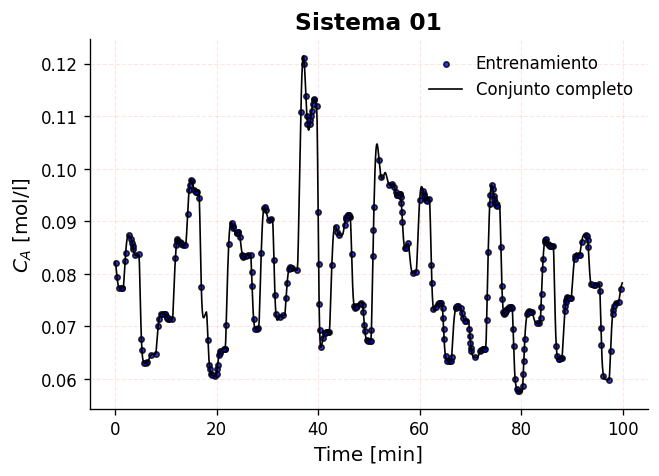

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

import random
random.seed(7)

fun = system_01
tamanio_paso = 0.1
tiempo_simulacion = 100
iteraciones = int(tiempo_simulacion / tamanio_paso)
cao = 0.082345311795785 # mol / L
To = 441.81 # K
qc = 100 # Coolant flow rate: L/min
sigma = 5

y1 = cao;
y2 = To;

y = []
u = []
u.append(qc)
y.append(y1)
tiempo = [i * tamanio_paso for i in range(iteraciones+1)]
contador = 0

for iter in range(iteraciones):
    contador += 1
    if iter == 0:
        qcr = qc + sigma * normalvariate();
    elif (contador > 10) and (abs(mean(y[iter-9:iter-3]) - mean(y[iter-2:iter-1])) < 0.0001):
        qcr = qc + sigma * normalvariate();
        contador = 0
    y1, y2 = runge_kutta_2(fun, y1, y2, qcr, tamanio_paso)
    y.append(y1)
    u.append(qcr)

df = pd.DataFrame({"t":tiempo[:-1], "y1":y[:-1], "y2":y[1:], "u":u[:-1]})

X = df[["t", "y1", "y2", "u"]]
Y = df["y1"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6666666666, random_state=42)

grafico_sistema(
    X["t"], X["y1"],
    X_train["t"], X_train["y1"],
    "Sistema 01",
    "Entrenamiento",
    "Conjunto completo",
    "Time [min]",
    "$C_A$ [mol/l]",
    "system01"
    )

df

/tmp/ipython-input-417520513.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yc.append(float(modelo.predict(x_iter)))


Coeficiente de determinación:  0.9463



,t,y1,y2,u,arx
0,0.0,0.082345,0.082012,100.000000,0.082345
1,0.1,0.082012,0.081246,98.220459,0.082574
2,0.2,0.081246,0.080309,98.220459,0.081561
3,0.3,0.080309,0.079391,98.220459,0.080781
4,0.4,0.079391,0.078603,98.220459,0.080179
...,...,...,...,...,...
995,99.5,0.076579,0.077185,98.551903,0.076994
996,99.6,0.077185,0.077670,98.551903,0.077481
997,99.7,0.077670,0.078028,98.551903,0.077857
998,99.8,0.078028,0.078271,98.551903,0.078146


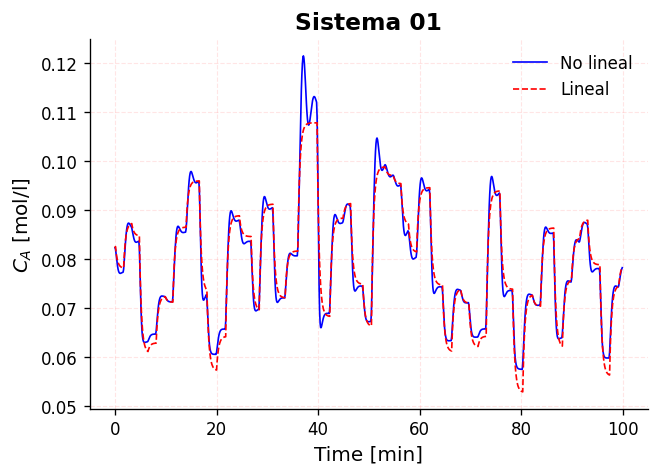

In [ ]:
#@title Construncción del ARX

## Importación y entrenamiento
import statsmodels.api as sm
x_constante = sm.add_constant(X_train[["y1", "u"]])
modelo = sm.OLS(X_train["y2"], x_constante).fit()

## Verificación
yc = [y[0]]
for i in range(df.shape[0] - 1):
  x_iter = [1, yc[-1], u[i]]
  yc.append(float(modelo.predict(x_iter)))
df["arx"] = yc

## Coeficiente de determinación
from sklearn.metrics import r2_score
r2 = r2_score(df["y2"], df["arx"])
print(f'Coeficiente de determinación: {r2: 0.4f}\n')

## Gráfico para comparar ARX con el modelo no lineal
grafico_comparacion(
    df["t"], df["y1"],
    df["t"], df["arx"],
    "Sistema 01",
    "No lineal",
    "Lineal",
    "Time [min]",
    "$C_A$ [mol/l]",
    "system01_comparacion"
    )

df

/tmp/ipython-input-19202136.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yc.append(float(modelo.predict(x_iter)))


Coeficiente de determinación:  0.9058



,t,y1,y2,u,arx
0,0.0,0.082345,0.083104,100.000000,0.082345
1,0.1,0.083104,0.084917,104.265324,0.082574
2,0.2,0.084917,0.087221,104.265324,0.085599
3,0.3,0.087221,0.089639,104.265324,0.087931
4,0.4,0.089639,0.091927,104.265324,0.089729
...,...,...,...,...,...
995,99.5,0.062658,0.062694,92.086760,0.060885
996,99.6,0.062694,0.062719,92.086760,0.060744
997,99.7,0.062719,0.062735,92.086760,0.060635
998,99.8,0.062735,0.062744,92.086760,0.060552


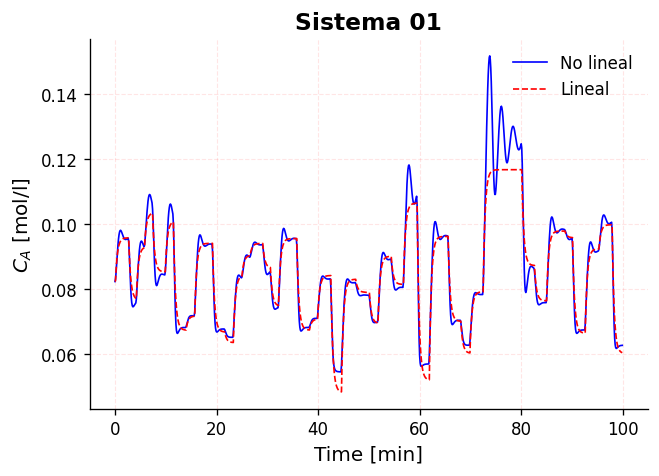

In [ ]:
#@title Validación del ARX
import pandas as pd
from sklearn.model_selection import train_test_split

import random
random.seed(27)

y1 = cao;
y2 = To;

y = []
u = []
u.append(qc)
y.append(y1)
contador = 0

for iter in range(iteraciones):
    contador += 1
    if iter == 0:
        qcr = qc + sigma * normalvariate();
    elif (contador > 10) and (abs(mean(y[iter-9:iter-3]) - mean(y[iter-2:iter-1])) < 0.0001):
        qcr = qc + sigma * normalvariate();
        contador = 0
    y1, y2 = runge_kutta_2(fun, y1, y2, qcr, tamanio_paso)
    y.append(y1)
    u.append(qcr)

df = pd.DataFrame({"t":tiempo[:-1], "y1":y[:-1], "y2":y[1:], "u":u[:-1]})

## validación
yc = [y[0]]
for i in range(df.shape[0] - 1):
  x_iter = [1, yc[-1], u[i]]
  yc.append(float(modelo.predict(x_iter)))
df["arx"] = yc

## Coeficiente de determinación
from sklearn.metrics import r2_score
r2 = r2_score(df["y2"], df["arx"])
print(f'Coeficiente de determinación: {r2: 0.4f}\n')

## Gráfico para comparar ARX con el modelo no lineal
grafico_comparacion(
    df["t"], df["y1"],
    df["t"], df["arx"],
    "Sistema 01",
    "No lineal",
    "Lineal",
    "Time [min]",
    "$C_A$ [mol/l]",
    "system01_comparacion"
    )

df

In [ ]:
c, a, b = tuple(modelo.params)

gs = arx1_to_Gs_analytic(a, b, 0.1)

print(gs)

<TransferFunction>: sys[24]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    0.002916
  ------------
  0.3843 s + 1


## Sistema 02: Reactor Continuo con Reacción de Van de Vusse

El Sistema 02 corresponde a un reactor continuo perfectamente agitado (CSTR) en el que se lleva a cabo la reacción de Van de Vusse. Este sistema es ampliamente utilizado como benchmark en control no lineal debido a su comportamiento fuertemente no lineal y a la presencia de cambios significativos en la ganancia del proceso en función del punto de operación.

### Esquema de reacción

El sistema químico involucra las siguientes reacciones consecutivas y paralelas:

$$A → B$$
$$B → C$$
$$2A → D$$


La reacción $A → B$ es la deseada, mientras que las demás representan rutas secundarias que afectan el rendimiento del producto intermedio B.

---

## Modelo dinámico

El modelo dinámico del reactor incluye balances de materia para las especies principales y un balance de energía. Los estados del sistema son:

* Concentración de A, ( $c_A$ )
* Concentración de B, ( $c_B$ )
* Temperatura del reactor, ( $T$ )
* Temperatura del refrigerante en la chaqueta, ( $T_J$ )

Las ecuaciones diferenciales que describen el sistema son:

### Balance de materia para A

$$
\frac{dc_A}{dt} =
\frac{F}{V_R}(c_{A0} - c_A) - k_1 c_A - k_3 c_A^2
  $$

### Balance de materia para B

$$
\frac{dc_B}{dt} =- \frac{F}{V_R} c_B+ k_1 c_A- k_2 c_B
  $$

### Balance de energía del reactor

$$
\frac{dT}{dt} =
\frac{F}{V_R}(T_0 - T)+ \frac{k_w A_R}{\rho C_p V_R}(T_J - T)
- \frac{1}{\rho C_p}
  \left(
  k_1 c_A \Delta H_{AB}
+ k_2 c_B \Delta H_{BC}
+ k_3 c_A^2 \Delta H_{AD}
  \right)
  $$

### Dinámica térmica de la chaqueta

$$
\frac{dT_J}{dt} =
\frac{1}{m_J C_{p,J}}
\left(
\dot Q_J
+ k_w A_R (T - T_J)
  \right)
  $$

Las constantes cinéticas dependen de la temperatura según relaciones tipo Arrhenius:

$$
k_i = k_{i,0} \exp\left(-\frac{E_i}{R T}\right),
\quad i = 1,2,3
$$

---

## Fuente de no linealidad

El sistema presenta múltiples fuentes de no linealidad estructural:

1. Término cuadrático ( $k_3 c_A^2$ ) en el balance de materia.
2. Dependencia exponencial de las constantes cinéticas con la temperatura.
3. Acoplamiento no lineal entre concentración y temperatura.
4. Cambio de ganancia del proceso dependiendo del punto de operación.

Una característica particularmente relevante es que, en ciertos rangos de operación, la ganancia estática del sistema puede cambiar de signo. Esto implica que el comportamiento dinámico alrededor de distintos puntos de equilibrio puede ser cualitativamente diferente, lo cual es una manifestación clara de no linealidad dependiente del punto de operación.

---

## Variable manipulada y salidas

La variable manipulada comúnmente considerada es la razón de flujo volumétrico ( $F / V_R$ ).

Las salidas típicamente analizadas incluyen:

* Concentración del producto intermedio ( $c_B$ )
* Temperatura del reactor ( $T$ )
* Otras concentraciones según el objetivo del estudio

---

## Clasificación de no linealidad

El reactor de Van de Vusse se clasifica como fuertemente no lineal. A diferencia de un CSTR simple, este sistema presenta:

* Dependencia paramétrica significativa con el punto de operación.
* Posible cambio de signo en la ganancia del proceso.
* Alta sensibilidad a variaciones en la entrada.
* Interacción no lineal entre múltiples estados.

Debido a estas características, este sistema constituye un caso de referencia para evaluar metodologías de cuantificación de no linealidad, identificación no lineal y diseño de controladores avanzados.

In [ ]:
def system_02(y1, y2, y3, y4, u):
  '''
    A Critical Discussion of the Continuous-Discrete Extended Kalman Filter
  Systematic methods and tools for managing the complexity
  Process Control (T4-8P)
  Prof John Bagterp Jørgensen
  Technical University of Denmark
  Informatics and Mathematical Modelling
  Informatics and Mathematical Modelling
  Richard Petersens Plads
  Building 305, Office 109
  Technical University of Denmark
  DK-2800 Kgs. Lyngby
  Denmark


  Keywords: State Estimation, Extended Kalman Filter, Stochastic Differential Equation

  In this paper, we derive and apply a novel numerically
  robust and computationally efficient extended Kalman
  filter for state estimation in nonlinear continuous-discrete
  stochastic systems. The continuous-discrete extended Kalman
  filter is applied to the Van der Vusse reaction example. This
  example is a well-known benchmark for nonlinear predictive
  control. Using the Van der Vusse example, we demonstrate
  inherent limitations of the extended Kalman filter and sensor
  structure for unbiased state estimation. In particular, we
  demonstrate that the convergence rate of the concentration
  estimate in the Van der Vusse system is limited by the frequency
  of concentration measurements. These limitations limit the
  achievable performance of any closed-loop system including
  nonlinear model predictive control.
  '''
  # Nominal steady state for the Van der Vusse CSTR

  cAs = 2.1402 # concentración de A en estado estable, mol / L
  cBs = 1.0903 # concentración de B en estado estable, mol / L
  Ts = 387.34 # temperatura en estado estable, K
  TJs = 386.06 # K
  # F = 141.9    # L / hr
  QJ = -1113.5 # kJ / hr
  # F_VR = 14.19 # 1 / hr

  # Parameters for the Van der Vusse CSTR
  k10 = 1.287e12 # 1 / hr
  k20 = 1.287e12 # 1 / hr
  k30 = 9.043e9  # L / (hr mol)
  E1_R = 9758.3  # E1 / R, K
  E2_R = 9758.3  # E2 / R, K
  E3_R = 8560.0  # K
  DHr1 = 4.2     # kJ/mol
  DHr2 = -11.0   # kJ/mol
  DHr3 = -41.85  # kJ/mol
  rho = 0.9342   # kg / L
  Cp = 3.01      # kJ / (kg K)
  kw = 4032.0    # kJ / (hr m2 K)
  AR = 0.215     # m2
  VR = 10.0      # L
  mJ = 5.0       # kg
  CpJ = 2.0      # kJ / (kg K)
  cA0 = 5.1      # mol / L
  T0 = 378.05    # K

  cA = y1
  cB = y2
  T = y3
  TJ = y4
  # u = F / VR

  r1 = k10 * exp(-E1_R / T) * cA
  r2 = k20 * exp(-E2_R / T) * cB
  r3 = k30 * exp(-E3_R / T) * cA ** 2

  dcA_dt = u * (cA0 - cA) - r1 - r3
  dcB_dt = -u * cB + r1 - r2
  dT_dt = u * (T0 - T) + kw * AR * (TJ - T) / (rho * Cp * VR) - (r1 * DHr1 + r2 * DHr2 + r3 * DHr3) / (rho * Cp)
  dTJ_dt = (QJ + kw * AR * (T - TJ)) / (mJ * CpJ)

  return dcA_dt, dcB_dt, dT_dt, dTJ_dt

,t,y1,y2,u
0,0.00,2.140211,2.242066,14.190000
1,0.01,2.242066,2.312816,18.272700
2,0.02,2.312816,2.361229,18.272700
3,0.03,2.361229,2.393872,18.272700
4,0.04,2.393872,2.415476,18.272700
...,...,...,...,...
995,9.95,1.907181,1.908755,11.466696
996,9.96,1.908755,1.910209,11.466696
997,9.97,1.910209,1.911546,11.466696
998,9.98,1.911546,1.912773,11.466696


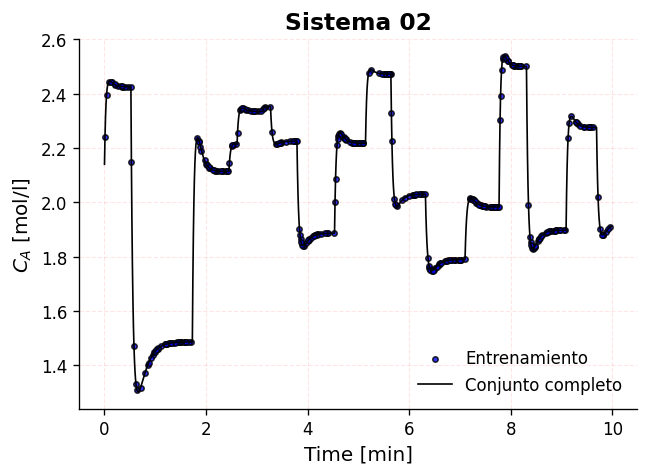

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

import random
random.seed(5)

fun = system_02
tamanio_paso = 0.01
tiempo_simulacion = 10
iteraciones = int(tiempo_simulacion / tamanio_paso)
cao = 2.1402105301319283
cbo = 1.0903043613295513
To = 387.34108442059727
Tjo = 386.0565929108151
qc = 14.19
sigma = 5

y1 = cao
y2 = cbo
y3 = To
y4 = Tjo

y = []
u = []
u.append(qc)
y.append(y1)
tiempo = [i * tamanio_paso for i in range(iteraciones+1)]
contador = 0

for iter in range(iteraciones):
    contador += 1
    if iter == 0:
        qcr = qc + sigma * normalvariate();
    elif (contador > 10) and (abs(mean(y[iter-9:iter-3]) - mean(y[iter-2:iter-1])) < 0.0001):
        qcr = qc + sigma * normalvariate();
        contador = 0
    y1, y2, y3, y4 = runge_kutta_4(fun, y1, y2, y3, y4, qcr, tamanio_paso)
    y.append(y1)
    u.append(qcr)

df = pd.DataFrame({"t":tiempo[:-1], "y1":y[:-1], "y2":y[1:], "u":u[:-1]})

X = df[["t", "y1", "y2", "u"]]
Y = df["y1"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6666666666, random_state=42)

grafico_sistema(
    X["t"], X["y1"],
    X_train["t"], X_train["y1"],
    "Sistema 02",
    "Entrenamiento",
    "Conjunto completo",
    "Time [min]",
    "$C_A$ [mol/l]",
    "system02"
    )
df

/tmp/ipython-input-417520513.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yc.append(float(modelo.predict(x_iter)))


Coeficiente de determinación:  0.9226



,t,y1,y2,u,arx
0,0.00,2.140211,2.242066,14.190000,2.140211
1,0.01,2.242066,2.312816,18.272700,2.133452
2,0.02,2.312816,2.361229,18.272700,2.198067
3,0.03,2.361229,2.393872,18.272700,2.248924
4,0.04,2.393872,2.415476,18.272700,2.288954
...,...,...,...,...,...
995,9.95,1.907181,1.908755,11.466696,1.890288
996,9.96,1.908755,1.910209,11.466696,1.890091
997,9.97,1.910209,1.911546,11.466696,1.889935
998,9.98,1.911546,1.912773,11.466696,1.889813


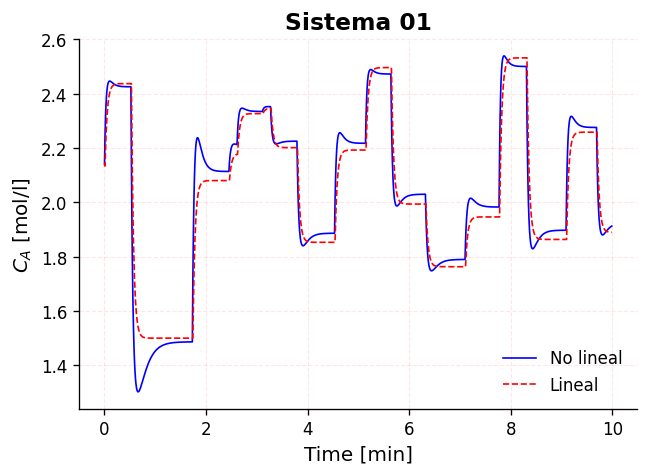

In [ ]:
#@title Construncción del ARX

## Importación y entrenamiento
import statsmodels.api as sm
x_constante = sm.add_constant(X_train[["y1", "u"]])
modelo = sm.OLS(X_train["y2"], x_constante).fit()

## Verificación
yc = [y[0]]
for i in range(df.shape[0] - 1):
  x_iter = [1, yc[-1], u[i]]
  yc.append(float(modelo.predict(x_iter)))
df["arx"] = yc

## Coeficiente de determinación
from sklearn.metrics import r2_score
r2 = r2_score(df["y2"], df["arx"])
print(f'Coeficiente de determinación: {r2: 0.4f}\n')

## Gráfico para comparar ARX con el modelo no lineal
grafico_comparacion(
    df["t"], df["y1"],
    df["t"], df["arx"],
    "Sistema 02",
    "No lineal",
    "Lineal",
    "Time [min]",
    "$C_A$ [mol/l]",
    "system02_comparacion"
    )

df

## Sistema 03: Reactor de Fermentación Continua

El Sistema 03 corresponde a un reactor continuo de fermentación, ampliamente utilizado como benchmark en estudios de control no lineal en bioprocesos. Este sistema presenta un nivel moderado de no linealidad, principalmente debido a la dependencia no lineal de la tasa específica de crecimiento microbiano respecto a la concentración de sustrato y producto.

A diferencia de los reactores puramente químicos, en este sistema la dinámica está gobernada por fenómenos biológicos, lo que introduce comportamientos no lineales adicionales asociados a la cinética microbiana.

---

## Modelo dinámico

El sistema se describe mediante tres ecuaciones diferenciales que representan:

* Concentración de biomasa ( $X$ )
* Concentración de sustrato ( $S$ )
* Concentración de producto ( $P$ )

### Balance de biomasa

$$
\frac{dX}{dt} = -D X + \mu X
$$

### Balance de sustrato

$$
\frac{dS}{dt} = D (S_f - S) - \frac{1}{Y_{X/S}} \mu X
$$

### Balance de producto

$$
\frac{dP}{dt} = -D P + (\alpha \mu + \beta) X
$$

donde:

* ( $D$ ) es la tasa de dilución (variable manipulada).
* ( $S_f$ ) es la concentración de sustrato en la alimentación.
* ( $Y_{X/S}$ ) es el rendimiento biomasa/sustrato.
* ( $\alpha$ ) y ( $\beta$ ) son parámetros asociados a la formación de producto.

La tasa específica de crecimiento microbiano ( \mu ) sigue una cinética no lineal del tipo:

$$
\mu =
\frac{\mu_m \left(1 - \frac{P}{P_m}\right)}
{K_m + S + \frac{S^2}{K_i}}
$$

---

## Fuente de no linealidad

El sistema presenta no linealidad estructural debido a:

1. Dependencia racional no lineal de la tasa de crecimiento respecto a la concentración de sustrato.
2. Inhibición por producto, representada por el término ( $1 - P/P_m$ ).
3. Acoplamiento multiplicativo entre estados (términos del tipo ($ \mu X$ )).

Estas características generan una dinámica no lineal suave pero significativa, particularmente en regiones donde el sustrato es bajo o el producto se aproxima a niveles de inhibición.

---

## Variable manipulada y salidas

La variable manipulada es la tasa de dilución ( $D$ ).

Las salidas comúnmente analizadas incluyen:

* Biomasa ( $X$ )
* Sustrato ( $S$ )
* Producto ( $P$ )

---

## Clasificación de no linealidad

Este sistema se clasifica como moderadamente no lineal. En comparación con los sistemas anteriores:

* Presenta mayor complejidad estructural que el Sistema 01 (CSTR simple).
* Es menos abruptamente no lineal que el Sistema 02 (Van de Vusse).
* No presenta cambios de signo en la ganancia, pero sí dependencia significativa del punto de operación.

La no linealidad se manifiesta principalmente en la variación de la dinámica efectiva cuando el sistema opera cerca de regiones de limitación o inhibición, lo cual lo convierte en un caso adecuado para evaluar métricas de no linealidad basadas en modelos lineales aproximados.

In [ ]:
def system_03(y1, y2, y3, u):
  '''
  Michael A. Henson, Dale E. Seborg,
  Nonlinear control strategies for continuous fermenters,
  Chemical Engineering Science,
  Volume 47, Issue 4,
  1992,
  Pages 821-835,
  ISSN 0009-2509,
  https://doi.org/10.1016/0009-2509(92)80270-M.
  (https://www.sciencedirect.com/science/article/pii/000925099280270M)
  Abstract: Nonlinear controllers based on exact linearization are designed and
  evaluated for continuous fermenters. The dilution rate and feed substrate
  concentration are considered as manipulated inputs in
  single-input/single-output strategies for productivity control.
  The resulting controllers are compared theoretically and via simulation.
  It is shown that state—space linearization techniques are not appropriate
  for this class of fermenters. Exact input—output-linearizing control
  employing the dilution rate as the manipulated input is shown to provide
  excellent regulatory behavior. Conversely, input—output linearization with
  the feed substrate concentration as the manipulated input is problematic.
  The exact approach yields unreasonably large control moves while an
  approximate technique recently proposed results in very sluggish responses.
  A modified approach to exact input—output linearization is proposed that
  results in satisfactory control.
  '''
  YX_S = 0.4  # g / g
  alpha = 2.2 # g / g
  beta = 0.2  # 1 / hr
  mium = 0.48 # 1 / hr
  Km = 1.2    # g / l
  Ki = 22.0   # g / l
  # D = 0.15    # 1 / hr
  Sf = 20.0   # g / l
  X = 7.038   # g / l
  S = 2.404   # g / l
  P = 24.87   # g / l
  Pm = 50.0   # g / l

  x1 = y1
  x2 = y2
  x3 = y3
  D = u

  miux = mium * (1 - x3 / Pm) * x2 / (Km + x2 + x2 ** 2 / Ki)

  dx1_dt = -D * x1 + miux * x1
  dx2_dt = D * (Sf - x2) - miux * x1 / YX_S
  dx3_dt = -D * x3 + (alpha * miux + beta) * x1

  return dx1_dt, dx2_dt, dx3_dt

,t,y1,y2,u
0,0.00,5.995600,6.023024,0.202001
1,0.25,6.023024,6.049660,0.183444
2,0.50,6.049660,6.075497,0.183444
3,0.75,6.075497,6.100526,0.183444
4,1.00,6.100526,6.124739,0.183444
...,...,...,...,...
3995,998.75,0.173652,0.172475,0.270688
3996,999.00,0.172475,0.171306,0.270688
3997,999.25,0.171306,0.170145,0.270688
3998,999.50,0.170145,0.168992,0.270688


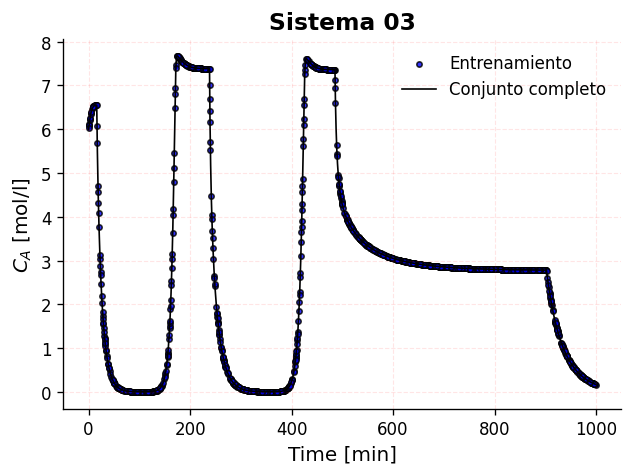

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

import random
# semilla = 19
# semilla += 1
semilla = 11
random.seed(semilla)

fun = system_03
tamanio_paso = 0.25
tiempo_simulacion = 1000
iteraciones = int(tiempo_simulacion / tamanio_paso)
cx = 5.9956
cs = 5.0109
cp = 19.1267
qc = 0.20200116423026032
sigma = 0.1

y1 = cx
y2 = cs
y3 = cp

y = []
u = []
u.append(qc)
y.append(y1)
tiempo = [i * tamanio_paso for i in range(iteraciones+1)]
contador = 0

for iter in range(iteraciones):
    contador += 1
    if iter == 0:
        qcr = qc + sigma * normalvariate();
    elif (contador > 10) and (abs(mean(y[iter-9:iter-3]) - mean(y[iter-2:iter-1])) < 0.0001):
        qcr = qc + sigma * normalvariate();
        contador = 0
    y1, y2, y3 = runge_kutta_3(fun, y1, y2, y3, qcr, tamanio_paso)
    y.append(y1)
    u.append(qcr)

df = pd.DataFrame({"t":tiempo[:-1], "y1":y[:-1], "y2":y[1:], "u":u[:-1]})

X = df[["t", "y1", "y2", "u"]]
Y = df["y1"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6666666666, random_state=42)

grafico_sistema(
    X["t"], X["y1"],
    X_train["t"], X_train["y1"],
    "Sistema 03",
    "Entrenamiento",
    "Conjunto completo",
    "Time [min]",
    "$C_A$ [mol/l]",
    "system03"
    )
df

/tmp/ipython-input-1884581884.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yc.append(float(modelo.predict(x_iter)))


Coeficiente de determinación:  0.6620



,t,y1,y2,u,arx
0,0.00,5.995600,6.023024,0.202001,5.995600
1,0.25,6.023024,6.049660,0.183444,5.983236
2,0.50,6.049660,6.075497,0.183444,5.975063
3,0.75,6.075497,6.100526,0.183444,5.966928
4,1.00,6.100526,6.124739,0.183444,5.958831
...,...,...,...,...,...
3995,998.75,0.173652,0.172475,0.270688,0.300556
3996,999.00,0.172475,0.171306,0.270688,0.299286
3997,999.25,0.171306,0.170145,0.270688,0.298022
3998,999.50,0.170145,0.168992,0.270688,0.296763


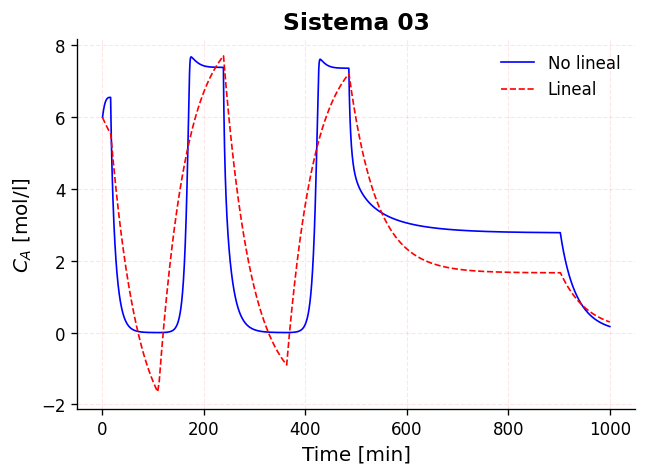

In [ ]:
#@title Construncción del ARX

## Importación y entrenamiento
import statsmodels.api as sm
x_constante = sm.add_constant(X_train[["y1", "u"]])
modelo = sm.OLS(X_train["y2"], x_constante).fit()

## Verificación
yc = [y[0]]
for i in range(df.shape[0] - 1):
  x_iter = [1, yc[-1], u[i]]
  yc.append(float(modelo.predict(x_iter)))
df["arx"] = yc

## Coeficiente de determinación
from sklearn.metrics import r2_score
r2 = r2_score(df["y2"], df["arx"])
print(f'Coeficiente de determinación: {r2: 0.4f}\n')

## Gráfico para comparar ARX con el modelo no lineal
grafico_comparacion(
    df["t"], df["y1"],
    df["t"], df["arx"],
    "Sistema 03",
    "No lineal",
    "Lineal",
    "Time [min]",
    "$C_A$ [mol/l]",
    "system01_comparacion"
    )

df

In [ ]:
from math import floor, ceil
def cuartil(x, k):
  z = list(x.copy())
  z.sort()
  n = len(z)
  i = k * (n + 1) / 4 - 1
  return z[floor(i)] + (i - floor(i)) * (z[ceil(i)] - z[floor(i)])


In [ ]:
a = [49.4, 49.1, 50.3, 49.7, 46.1, 48.3, 48.9, 51.9, 52.2, 48.8, 46.9, 54.6]
b = [47.9, 51.5, 55.2, 47.1, 48.7, 50.2, 52.8, 50.5, 50.4, 49.4, 55.6, 47.4, 51.5, 48.4, 52.2]

import numpy as np

a = np.array(a)
b = np.array(b)

cuartil(b,2)

np.float64(50.4)

In [ ]:
np.random.normal(51, 2, size = 15).round(1)

array([49.4, 46.9, 49.4, 49.3, 51.9, 48.9, 48. , 51.9, 48.7, 51.6, 50.8,
       46.4, 52.1, 50.8, 50.6])